In [1]:
import DeepMIMO
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy.io import loadmat, savemat

In [2]:
# Load the default parameters
parameters = DeepMIMO.default_params()

# Set scenario name
parameters['scenario'] = 'O1_60'

# Set the main folder containing extracted scenarios
parameters['dataset_folder'] = r'C:\\Users\\emre.topcu\\Desktop\\ulakws\\scenarios\\O1_60'

In [3]:
# Only include 10 strongest paths in the channel computation, set
parameters['num_paths'] = 5

# User rows 
parameters['user_row_first'] = 1000
parameters['user_row_last'] = 1300
# Activate the half of the users in each selected row randomly, set

# Activate the specific basestations
parameters['active_BS'] = np.array([3, 4, 5, 6]) 

# Total bandwidth of the channel in GHz. 
parameters['OFDM']['bandwidth'] = 0.5
# Generate OFDM channels with 256 subcarriers
parameters['OFDM']['subcarriers'] = 1024 # OFDM with 1024 subcarriers
# Construct channels that will be calculated only at the sampled subcarriers
parameters['OFDM']['subcarriers_limit'] = 64 # Keep only first 64 subcarriers

# Enable (1) or disable (0) generation of the channels between basestations
parameters['enable_BS2BS'] = False

parameters['ue_antenna']['shape'] = np.array([1, 1, 1]) # Single antenna

# Adopt a 32x4 UPA in y-z directions
parameters['bs_antenna']['shape'] = np.array([1, 32, 8]) # ULA of 32 elements

parameters['bs_antenna']['radiation_pattern'] = 'halfwave-dipole'
parameters['ue_antenna']['radiation_pattern'] = 'halfwave-dipole'

In [31]:
# Generate data
dataset = DeepMIMO.generate_data(parameters)

# Print the default parameters
for i,j in parameters.items():
    print(i,": ,", j)



Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 54481/54481 [01:06<00:00, 819.70it/s] 



Basestation 4

UE-BS Channels


Generating channels: 100%|██████████| 54481/54481 [01:13<00:00, 737.47it/s] 



Basestation 5

UE-BS Channels


Generating channels: 100%|██████████| 54481/54481 [01:17<00:00, 700.83it/s]



Basestation 6

UE-BS Channels


Generating channels: 100%|██████████| 54481/54481 [01:24<00:00, 643.14it/s]

dataset_folder : , C:\\Users\\emre.topcu\\Desktop\\ulakws\\scenarios\\O1_60
scenario : , O1_60
dynamic_settings : , {'first_scene': 1, 'last_scene': 1}
num_paths : , 5
active_BS : , [3 4 5 6]
user_row_first : , 1000
user_row_last : , 1300
row_subsampling : , 1
user_subsampling : , 1
bs_antenna : , [{'shape': array([ 1, 32,  8]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': None}, {'shape': array([ 1, 32,  8]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': None}, {'shape': array([ 1, 32,  8]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': None}, {'shape': array([ 1, 32,  8]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': None}]
ue_antenna : , {'shape': array([1, 1, 1]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': array([None, None, None, ..., None, None, None], dtype=object)}
enable_BS2BS : , False
OFDM_channels : , 1
OFDM : , {'subcarriers': 1024, 'subcarriers_limit': 64, 's

In [36]:
print("Shape of the dataset: ", dataset[0]['user']['channel'].shape)
print("Shape of the dataset: (ue_count, number of RX antennas, number of TX antennas, subcarrier_lmt) \n")
print("Number of TX antennas: ", len(dataset))
print("BS1 Location: ", dataset[0]['location'],"\n")
print("UE specifications: ", dataset[0]['user'].keys())

Shape of the dataset:  (54481, 1, 256, 64)
Shape of the dataset: (ue_count, number of RX antennas, number of TX antennas, subcarrier_lmt) 

Number of TX antennas:  4
BS1 Location:  [235.5039978 489.5039978   6.       ] 

UE specifications:  dict_keys(['paths', 'LoS', 'location', 'distance', 'pathloss', 'channel'])


In [37]:
def beamforming_codebook(ant_shape = np.array([1, 32, 1]), oversampling_rate = np.array([1, 1, 1]), kd = 0.5):
    
    kd = 2 * np.pi * kd
    codebook_size = ant_shape * oversampling_rate
    
    vecs = []
    for dim in range(3):
        # Transpose
        ind = np.arange(ant_shape[dim]).reshape((-1, 1))
        codebook_ang = np.linspace(0, np.pi, codebook_size[dim], endpoint = False).reshape((1, -1))                                                                                                     
        vec = np.sqrt(1./ant_shape[dim]) * np.exp(-1j * kd * ind * np.cos(codebook_ang))
        vecs.append(vec)
        
    F = np.kron(vecs[2], np.kron(vecs[1], vecs[0]))
    
    return F

In [38]:
# Codebook values
F = beamforming_codebook(ant_shape = parameters['bs_antenna'][0]['shape'], oversampling_rate = np.array([1, 2, 1]), kd = parameters['bs_antenna'][0]['spacing'])

In [39]:
F.shape

(256, 512)

In [40]:
num_OFDM = int(parameters['OFDM']['subcarriers_limit']/parameters['OFDM']['subcarriers_sampling'])
num_beams = F.shape[1]
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])

print("Number of OFDM subcarrier limit: ", num_OFDM)
print("Number of beams: ", num_beams)
print("Number of active BSs: ", num_bs)
print("Number of active UEs: ", num_ue)

Number of OFDM subcarrier limit:  64
Number of beams:  512
Number of active BSs:  4
Number of active UEs:  54481


In [41]:
# Noise figure at the base station
NF = 5
# Channel estimation processing gain          
Process_Gain = 10
# System bandwidth in Hz
BW = parameters['OFDM']['bandwidth'] * 1e9
# Noise power in dB
noise_power_dB = -204 + 10*np.log10(BW/parameters['OFDM']['subcarriers']) + NF - Process_Gain
# Noise power
noise_power = 10**(.1*(noise_power_dB))

In [42]:
def normalization_reshape(dataset, num_bs, num_ue, num_OFDM, num_beams):
    """
    Normalization and reshaping processes on model input-output data.

    Args:
        dataset (_type_): Ray tracing simulation results
        num_bs (_type_): Number of base stations
        num_ue (_type_): Number of user equipments
        num_OFDM (_type_): Number of OFDM subcarrier limi
        num_beams (_type_): Number of beams in codebook
    
    Returns:
        
    """
    input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
    max_rates = np.zeros((num_bs, num_ue, num_beams))
    
    # Each BS
    for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
        # Each UE
        for ue_idx in tqdm(range(num_ue), desc='Neural Network Input-Output Generation-BS-%i'%bs_idx, position=0, leave=True):
            ch = dataset[bs_idx]['user']['channel'][ue_idx].squeeze()
            ch = ch + np.sqrt(noise_power) * (np.random.randn(*(ch.shape)) + 1j * np.random.randn(*(ch.shape)))
            input_norm[bs_idx, ue_idx, :] = ch[0, :]
            max_rates[bs_idx, ue_idx, :] = np.sum(np.log2(1 + np.abs(ch.T.conj() @ F)**2),  axis = 0)/num_OFDM
        
    # Input reshape - normalize
    print("\nShape of input before normalization: ", input_norm.shape)
    input_norm = np.transpose(input_norm, axes=[1, 0, 2]) # [x y z] -> [y, x, z]
    input_norm = input_norm.reshape((num_ue, -1)) # [y, x ,z] -> [y, z_x0 z_x1]
    input_norm /=  np.amax(np.abs(input_norm))
    print("Shape of input after normalization: ", input_norm.shape, "\n")
    
    # Output reshape - normalize
    print("Shape of output before normalization: ", max_rates.shape)
    max_rates_norm_factor = np.amax(max_rates, axis=2, keepdims=True)
    # Do not normalize if all zeros
    max_rates_norm_factor[max_rates_norm_factor == 0] = 1
    max_rates /= max_rates_norm_factor
    max_rates = np.transpose(max_rates, axes=[1, 0, 2]) # [x y z] -> [y, x, z]
    max_rates = max_rates.reshape((num_ue, -1)) # [y, x ,z] -> [y, z_x0 z_x1]
    print("Shape of output before normalization: ", max_rates.shape)
    
    if not os.path.exists('./DLCB_dataset'):
                      os.makedirs('DLCB_dataset')
    savemat('./DLCB_dataset/DLCB_input.mat', {'DL_input': input_norm})
    savemat('./DLCB_dataset/DLCB_output.mat', {'DL_output': max_rates})
    
    return

In [43]:
normalization_reshape(dataset, num_bs, num_ue, num_OFDM, num_beams)

Neural Network Input-Output Generation-BS: 100%|██████████| 4/4 [15:23<00:00, 230.96s/it]



Shape of input before normalization:  (4, 54481, 64)
Shape of input after normalization:  (54481, 256) 

Shape of output before normalization:  (4, 54481, 512)
Shape of output before normalization:  (54481, 2048)


In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

x=np.zeros(num_ue + num_bs)
y=np.zeros(num_ue + num_bs)
z=np.zeros(num_ue + num_bs)

# BS locations
for bs_idx in range(num_bs):
    x[bs_idx] = dataset[bs_idx]['location'][0]
    y[bs_idx] = dataset[bs_idx]['location'][1]
    z[bs_idx] = dataset[bs_idx]['location'][2]
    # UE locations  3 -> x,y,z (0,1,2)
    for ue_idx in range(0, num_ue):
        idx = ue_idx + num_bs
        x[idx] = dataset[bs_idx]['user']['location'][ue_idx][0]
        y[idx] = dataset[bs_idx]['user']['location'][ue_idx][1]
        z[idx] = dataset[bs_idx]['user']['location'][ue_idx][2]
        
ttl = plt.title('UE and BS Positions')

# Plotting UE and BS locations on 3D space
ax.scatter(x[:num_bs], y[:num_bs], z[:num_bs], c='red')
ax.scatter(x[num_bs:], y[num_bs:], z[num_bs:], c='blue')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

pathloss = dataset[bs_idx]['user']['pathloss']
# BS locations
ax.scatter(x[:num_bs], y[:num_bs], z[:num_bs], c='red')
# UE locations
im = ax.scatter(x[num_bs:], y[num_bs:], c=pathloss)

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
fig.colorbar(im, ax=ax)
title = plt.title('UE Grid Path-loss (dB)')
plt.legend(["Base Stations", "User Equipments"])


In [ ]:
## Visualization of a channel matrix
fig = plt.figure()
ax = fig.add_subplot()

# Visualize channel magnitude response
ue_idx = 200
bs_idx = 0

# Import channel
channel = dataset[bs_idx]['user']['channel'][ue_idx]

fig.colorbar(channel, ax=ax)

# Take only the first antenna pair
plt.imshow(np.abs(np.squeeze(channel).T))
plt.title('Channel Magnitude Response')
plt.xlabel('TX Antennas')
plt.ylabel('Subcarriers')

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from datetime import datetime
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [12]:
now = datetime.now()
formatted_date = now.strftime('%Y-%m-%d/%H_%M_%S')
print(formatted_date)

2024-08-20/09_04_17


In [13]:
# Reading input and output sets generated from MATLAB
input_set_file=loadmat('DLCB_dataset/DLCB_input.mat')
output_set_file=loadmat('DLCB_dataset/DLCB_output.mat')

input_set=input_set_file['DL_input']
output_set=output_set_file['DL_output']

In [14]:
def train(model_func, model_name, x_train, y_train, x_test, y_test,
          EPOCHS, BATCH_SIZE, dr, num_hidden_layers, nodes_per_layer,
          opt, loss_fn, num_bs, n_beams, filepath, lr=None, lr_schedule=None, l2_reg=0.01):
    """
    Trains a list of neural network models, one for each base station.

    Parameters:
    - model_func: Function to create the model
    - model_name: Name of the model
    - x_train: Training input data
    - y_train: Training output data
    - x_test: Testing input data
    - y_test: Testing output data
    - EPOCHS: Number of epochs to train the models
    - BATCH_SIZE: Batch size for training
    - dr: Dropout rate
    - num_hidden_layers: Number of hidden layers in the model
    - nodes_per_layer: Number of nodes per hidden layer
    - opt : Selected optimizer
    - loss_fn: Loss function to use for training
    - num_bs: Number of base stations
    - n_beams: Number of beams per base station
    - filepath: Path to save the best model during training
    - lr: Learning rate for the optimizer
    - lr_schedule: If a learning schedule is implemented { 'decay_rate' : .., 'decay}
    - l2_reg: L2 regularization factor (default is 0.01).

    Returns:
    - AP_models: List of trained models, one for each base station
    """
    input_shape = list(x_train.shape[1:])
    
    # Initialize an empty list to store the trained models for each base station
    AP_models = []
    
    # Iterate over each base station to create and train a model
    for bs_idx in range(num_bs):
        # Generate a unique identifier for the current base station
        idx_str = f'BS{bs_idx}'
        idx = bs_idx*n_beams
        print("The training of the BS: ", idx_str)
        
        # Create a new model for the current base station using the UlakNET
        model = model_func(input_shape, nodes_per_layer, num_hidden_layers, dr, n_beams, idx_str, l2_reg)
        
        # Initialize optimizer kwargs
        optimizer_kwargs = {}

        # Add learning_rate to optimizer_kwargs only if lr is not None
        if lr is not None:
            optimizer_kwargs['learning_rate'] = lr

        # Compile the model with the specified learning rate
        optimizer_class = getattr(optimizers, opt)
        optimizer_instance = optimizer_class(**optimizer_kwargs)

        model.compile(loss=loss_fn, optimizer=optimizer_instance)

        # Initialize callbacks
        callbacks = [
            # Save the best model based on validation loss
            keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto'),
            # Stop training early if validation loss does not improve
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)
        ]

        # Add learning rate scheduler callback if lr_schedule is not None
        if lr_schedule is not None:
            
            def lr_scheduler(epoch, lr, decay_rate=0.1, decay_epochs=10):
                if epoch % decay_epochs == 0 and epoch != 0:
                    new_lr = lr * decay_rate
                    return new_lr
                return lr

            lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr_scheduler(epoch, lr, lr_schedule['decay_rate'], lr_schedule['decay_epochs']))
            callbacks.append(lr_scheduler_callback)

        model.compile(loss=loss_fn, optimizer=optimizer_instance)
        
        model.fit(x_train, y_train[:, idx:idx + n_beams],
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 2,
                    validation_data = (x_test, y_test[:,idx:idx + n_beams]),
                    callbacks = callbacks)
            
        # Append the trained model to the list of models
        AP_models.append(model)
        print("Finished the training of the BS: ", idx_str, "\n")  
    return AP_models

In [15]:
def DeepMIMONET(input_shape, nodes_per_layer, num_hidden_layers, dr, n_beams, idx_str, l2_reg=None):
    """
    Creates and returns a Sequential neural network model.

    Parameters:
    - input_shape: Shape of the input data (excluding batch size).
    - nodes_per_layer: Number of nodes in each hidden layer.
    - num_hidden_layers: Number of hidden layers.
    - dr: Dropout rate.
    - n_beams: Number of output units (beams).
    - idx_str: Index of a specific BS (Base Station).
    - l2_reg: L2 regularization factor (default is 0.01).

    Returns:
    - model: Compiled Keras Sequential model.
    """
    # Initialize a Sequential model
    model = models.Sequential()

    # Input layer with Dropout
    model.add(layers.Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(layers.Dropout(dr))
        
    
    # Hidden layers
    for h in range(num_hidden_layers):
        model.add(layers.Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal'))
        model.add(layers.Dropout(dr))

    # Output layer
    model.add(layers.Dense(n_beams, activation='relu', kernel_initializer='he_normal',
                name="dense" + idx_str + "o"))
    return model

In [16]:
def UlakNET(input_shape, nodes_per_layer, num_hidden_layers, dr, n_beams, idx_str, l2_reg=0.01):
    """
    Creates and returns a neural network model using the Functional API.

    Parameters:
    - input_shape: Shape of the input data (excluding batch size).
    - nodes_per_layer: Number of nodes in each hidden layer.
    - num_hidden_layers: Number of hidden layers.
    - dr: Dropout rate.
    - n_beams: Number of output units (beams).
    - idx_str: Index of a specific BS (Base Station).
    - l2_reg: L2 regularization factor (default is 0.01).

    Returns:
    - model: Compiled Keras model.
    """

    # Input layer with Dropout
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Dense(nodes_per_layer, activation=None,
                     kernel_initializer='he_normal',
                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    #x = layers.Dropout(dr)(x)

    # Hidden layers
    for _ in range(num_hidden_layers):
        x = layers.Dense(nodes_per_layer, activation=None,
                         kernel_initializer='he_normal',
                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        #x = layers.Dropout(dr)(x)

    # Output layer
    outputs = layers.Dense(n_beams, activation='linear',
                           kernel_initializer='he_normal',
                           name=f"dense_{idx_str}_output")(x)

    model = models.Model(inputs, outputs)
    return model

In [19]:
def UlakConv2D_Net(input_shape, nodes_per_layer, num_hidden_layers, 
                dr, n_beams, idx_str, l2_reg=0.01, num_filters=32, 
                kernel_size=(5, 5), pool_size=(2, 2), num_conv_layers=3):
    """
    Creates and returns a CNN model using the Functional API for 2D input data.

    Parameters:
    - input_shape: Shape of the input data (excluding batch size).
    - num_filters: Number of filters in each convolutional layer.
    - kernel_size: Size of the convolutional kernels (tuple for 2D).
    - pool_size: Size of the max pooling windows (tuple for 2D).
    - num_conv_layers: Number of convolutional layers.
    - nodes_per_layer: Number of nodes in each dense layer.
    - num_hidden_layers: Number of hidden dense layers.
    - dr: Dropout rate.
    - n_beams: Number of output units (beams).
    - idx_str: Index of a specific BS (Base Station).
    - l2_reg: L2 regularization factor (default is 0.01).

    Returns:
    - model: Compiled Keras model.
    """

    # Input layer
    inputs = layers.Input(shape=input_shape)  # Ensure input_shape is (height, width, channels)
    
    # Convolutional layers
    x = inputs
    
    # Reshape the input to a square-like structure (e.g., 16x16)
    x = layers.Reshape((16, 16, 1))(inputs)  # Now (16, 16, 1)
    
    for _ in range(num_conv_layers):
        x = layers.Conv2D(num_filters, kernel_size, activation=None, padding='same',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        #x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=pool_size)(x)
        x = layers.Dropout(dr)(x)

    # Flatten the output of the convolutional layers
    x = layers.Flatten()(x)

    # Dense layers
    for _ in range(num_hidden_layers):
        x = layers.Dense(nodes_per_layer, activation=None,
                         kernel_initializer='he_normal',
                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        #x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dr)(x)

    # Output layer
    outputs = layers.Dense(n_beams, activation='relu',
                           kernel_initializer='he_normal',
                           name=f"dense_{idx_str}_output")(x)

    model = models.Model(inputs, outputs)
    return model

In [20]:
def UlakLSTM_Net(input_shape, nodes_per_layer, num_hidden_layers, 
                dr, n_beams, idx_str, l2_reg=0.01, num_lstm_units=96, 
                num_lstm_layers=4):
    """
    Creates and returns an LSTM RNN model using the Functional API for sequential input data.

    Parameters:
    - input_shape: Shape of the input data (excluding batch size).
    - num_lstm_units: Number of units in each LSTM layer.
    - num_lstm_layers: Number of LSTM layers.
    - nodes_per_layer: Number of nodes in each dense layer.
    - num_hidden_layers: Number of hidden dense layers.
    - dr: Dropout rate.
    - n_beams: Number of output units (beams).
    - idx_str: Index of a specific BS (Base Station).
    - l2_reg: L2 regularization factor (default is 0.01).

    Returns:
    - model: Compiled Keras model.
    """

    # Input layer
    inputs = layers.Input(shape=input_shape)  # Ensure input_shape is (timesteps, features)
    
    # Reshape input if necessary to add the time dimension
    x = layers.Reshape((1, input_shape[0]))(inputs)
    
    for i in range(num_lstm_layers):
        return_sequences = i < num_lstm_layers - 1  # Return sequences only for the intermediate layers
        x = layers.LSTM(num_lstm_units, return_sequences=return_sequences, activation=None,
                        kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        #x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dr)(x)
    
    # Dense layers
    for _ in range(num_hidden_layers):
        x = layers.Dense(nodes_per_layer, activation=None,
                         kernel_initializer='he_normal', 
                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        #x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dr)(x)

    # Output layer
    outputs = layers.Dense(n_beams, activation='linear',
                           kernel_initializer='he_normal',
                           name=f"dense_{idx_str}_output")(x)

    model = models.Model(inputs, outputs)
    return model


In [21]:
def UlakBiLSTM_Net(input_shape, nodes_per_layer, num_hidden_layers, 
                dr, n_beams, idx_str, l2_reg=0.01, num_lstm_units=16, 
                num_lstm_layers=3):
    """
    Creates and returns an LSTM RNN model using the Functional API for sequential input data.

    Parameters:
    - input_shape: Shape of the input data (excluding batch size).
    - num_lstm_units: Number of units in each LSTM layer.
    - num_lstm_layers: Number of LSTM layers.
    - nodes_per_layer: Number of nodes in each dense layer.
    - num_hidden_layers: Number of hidden dense layers.
    - dr: Dropout rate.
    - n_beams: Number of output units (beams).
    - idx_str: Index of a specific BS (Base Station).
    - l2_reg: L2 regularization factor (default is 0.01).

    Returns:
    - model: Compiled Keras model.
    """

    # Input layer
    inputs = layers.Input(shape=input_shape)  # Ensure input_shape is (timesteps, features)
    
    # Reshape input if necessary to add the time dimension
    x = layers.Reshape((1, input_shape[0]))(inputs)
    
    for i in range(num_lstm_layers):
        return_sequences = i < num_lstm_layers - 1  # Return sequences only for the intermediate layers
        x = layers.Bidirectional(
                layers.LSTM(num_lstm_units, return_sequences=return_sequences, activation=None,
                            kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
            )(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dr)(x)
    
    # Dense layers
    for _ in range(num_hidden_layers):
        x = layers.Dense(nodes_per_layer, activation=None,
                         kernel_initializer='he_normal',
                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dr)(x)

    # Output layer
    outputs = layers.Dense(n_beams, activation='linear',
                           kernel_initializer='he_normal',
                           name=f"dense_{idx_str}_output")(x)

    model = models.Model(inputs, outputs)
    return model


In [35]:
n_DL_size=[ .05, .1, .15, .2, .25, .3]
cnt=0

for DL_size_ratio in n_DL_size:
    
    print("Training with the *", DL_size_ratio, "% * of the dataset")
    cnt += 1
    DL_size = int(num_ue * DL_size_ratio)
    print("Initializing...")
    
    # Train/Test Split
    np.random.seed(42)
    num_train = int(DL_size * 0.8)
    num_test = int(num_ue * 0.2)
    
    # Randomly select train and test indices
    train_index = np.random.choice(range(0,num_ue), size=num_train, replace=False)
    rem_index = set(range(0,num_ue))-set(train_index)
    test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))
    
    print("--------------------")
    print("DL size: ", DL_size)
    print("train_size: ", len(train_index))
    print("test_size: ", len(test_index))
    print("--------------------")
   
    # Prepare training and testing data
    x_train = np.real(input_set[train_index])
    x_test = np.real(input_set[test_index])
    
    y_train = output_set[train_index]
    y_test = output_set[test_index]
        
    print("Setting Learning Parameters...\n")
    # Learning model parameters
    
    UlakNET_params = {'epochs' : 40,
                        'batch_size' : 4,
                        'dr' : 0.3,
                        'lr' : 0.01,
                        'l2_reg' : 0.001,
                        'num_hidden_layers' : 3,
                        'nodes_per_layer' : x_train.shape[1] * 2,
                        'optimizer' : 'Adam',
                        'lr_schedule' : { 'decay_rate' : 0.5, 'decay_epochs' : 10 },
                        'loss_fn' : 'mean_squared_logarithmic_error',
                        'filepath' : f"./models/model_{formatted_date}_UlakNET.weights.h5"}
    
    UlakCNNNET_params = {'epochs' : 100,
                        'batch_size' : 100,
                        'dr' : 0.01,
                        'lr' : None,
                        'l2_reg' : None,
                        'num_hidden_layers' : 4,
                        'nodes_per_layer' : x_train.shape[1],
                        'optimizer' : 'Adam',
                        'lr_schedule' : None,
                        'loss_fn' : 'mean_squared_logarithmic_error',
                        'filepath' : f"./models/model_{formatted_date}_UlakCNNNET.weights.h5"}

    DeepMIMONET_params = {'epochs' : 20,
                        'batch_size' : 100,
                        'dr' : 0.05,
                        'lr' : None,
                        'l2_reg' : None,
                        'num_hidden_layers' : 4,
                        'nodes_per_layer' : x_train.shape[1],
                        'optimizer' : 'Adam',
                        'lr_schedule' : None,
                        'loss_fn' : 'mean_squared_error',
                        'filepath' : f"./models/model_{formatted_date}_DeepMIMONET.weights.h5"}
    
    UlakConv1D_Net_params = {'epochs' : 60,
                        'batch_size' : 128,
                        'dr' : 0.02,
                        'lr' : None,
                        'l2_reg' : None,
                        'num_hidden_layers' : 4,
                        'nodes_per_layer' : x_train.shape[1],
                        'optimizer' : 'Adam',
                        'lr_schedule' : None,
                        'loss_fn' : 'mean_squared_error',
                        'filepath' : f"./models/model_{formatted_date}_UlakConv1D_Net.weights.h5"}
    
    UlakConv2D_Net_params = {'epochs' : 100,
                        'batch_size' : 8,
                        'dr' : 0.04,
                        'lr' : 0.004,
                        'l2_reg' : 0.000001,
                        'num_hidden_layers' : 3,
                        'nodes_per_layer' : int(x_train.shape[1]*0.6),
                        'optimizer' : 'Adam',
                        'lr_schedule' : { 'decay_rate' : 0.45, 'decay_epochs' : 10 },
                        'loss_fn' : 'mean_squared_logarithmic_error',
                        'filepath' : f"./models/model_{formatted_date}_UlakConv2D_Net.weights.h5"}
    
    UlakLSTM_Net_params = {'epochs' : 200,
                        'batch_size' : 16,
                        'dr' : 0.1,
                        'lr' : 0.003,
                        'l2_reg' : 0.00000001,
                        'num_hidden_layers' : 1,
                        'nodes_per_layer' : int(x_train.shape[1]*0.25),
                        'optimizer' : 'Adam',
                        'lr_schedule' : { 'decay_rate' : 0.55, 'decay_epochs' : 8 },
                        'loss_fn' : 'mean_squared_logarithmic_error',
                        'filepath' : f"./models/model_{formatted_date}_UlakLSTMM_Net.weights.h5"}
    
    UlakBiLSTM_Net_params = {'epochs' : 200,
                        'batch_size' : 8,
                        'dr' : 0.04,
                        'lr' : 0.004,
                        'l2_reg' : 0.0000001,
                        'num_hidden_layers' : 3,
                        'nodes_per_layer' : int(x_train.shape[1]*0.4),
                        'optimizer' : 'Adam',
                        'lr_schedule' : { 'decay_rate' : 0.65, 'decay_epochs' : 12 },
                        'loss_fn' : 'mean_squared_logarithmic_error',
                        'filepath' : f"./models/model_{formatted_date}_UlakBiLSTM_Net.weights.h5"}

    model_functions = { 'UlakLSTM_Net' : UlakLSTM_Net}
    
    model_args = { 'UlakLSTM_Net' : UlakLSTM_Net_params}
    
    for model_name,args in model_args.items(): 
        # Model training
        print("Starting Model Training: ", model_name)
        
        model_func = model_functions[model_name]
        
        if model_name == 'UlakCNNNET' or  model_name == 'UlakConv1D_Net' or model_name == 'UlakConv2D_Net':
            # Reshape x_train to (num_samples, steps, input_dim)
            # Here, we'll assume steps = 1 and input_dim = 256
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
            
        AP_models = train(
            model_func, model_name, x_train, y_train, x_test, y_test,
            args['epochs'], args['batch_size'], args['dr'],args['num_hidden_layers'],
            args['nodes_per_layer'],args['optimizer'], args['loss_fn'], num_bs, num_beams, 
            args['filepath'], args['lr'], args['lr_schedule'], args['l2_reg']
        )
    
        print("Evaluating Model: ", model_name)
        DL_Result = {}

        for bs_indx in range(0,num_bs,1): 
            beams_predicted=AP_models[bs_indx].predict(x_test, batch_size=10, verbose=0)
            DL_Result['TX'+str(bs_indx+1)+'Pred_Beams'] = beams_predicted
            DL_Result['TX'+str(bs_indx+1)+'Opt_Beams'] = y_test[:,bs_indx*num_beams:(bs_indx+1)*num_beams]

        DL_Result['user_index']=test_index


        # Ensure the directory exists before saving
        output_dir = os.path.join('DLCB_code_output', 'DL_Result')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        output_file = os.path.join(output_dir, f'{model_name}{cnt}.mat')
        savemat(output_file, DL_Result)
        print("Iteration completed for model: " + model_name, cnt, "/", len(n_DL_size), "\n")
print("Training/Evaluation session finished!")

Training with the * 0.05 % * of the dataset
Initializing...
--------------------
DL size:  2724
train_size:  2179
test_size:  10896
--------------------
Setting Learning Parameters...

Starting Model Training:  UlakLSTM_Net
The training of the BS:  BS0
Epoch 1/200
137/137 - 16s - 117ms/step - loss: 0.0020 - val_loss: 0.0019 - learning_rate: 0.0030
Epoch 2/200
137/137 - 3s - 21ms/step - loss: 0.0018 - val_loss: 0.0016 - learning_rate: 0.0030
Epoch 3/200
137/137 - 3s - 25ms/step - loss: 0.0015 - val_loss: 0.0014 - learning_rate: 0.0030
Epoch 4/200
137/137 - 3s - 24ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 0.0030
Epoch 5/200
137/137 - 3s - 21ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 0.0030
Epoch 6/200
137/137 - 3s - 18ms/step - loss: 0.0011 - val_loss: 0.0012 - learning_rate: 0.0030
Epoch 7/200
137/137 - 3s - 19ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 0.0030
Epoch 8/200
137/137 - 3s - 19ms/step - loss: 9.8678e-04 - val_loss: 0.0011 - lea

KeyboardInterrupt: 

In [23]:
import glob
import re

In [25]:
DeepMIMONET_file_list = sorted(glob.glob('DLCB_code_output/DL_Result/DeepMIMONET*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
#UlakNET_file_list = sorted(glob.glob('DLCB_code_output/DL_Result/UlakNET*.mat'), key=lambda x: int(re.findall(r'\d+', x)[0]))
#UlakCNNNET_file_list = sorted(glob.glob('DLCB_code_output/DL_Result/UlakCNNNET*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
UlakConv2D_Net_file_list = sorted(glob.glob('DLCB_code_output/DL_Result/UlakConv2D_Net*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
UlakLSTM_Net_file_list = sorted(glob.glob('DLCB_code_output/DL_Result/UlakLSTM_Net*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
#UlakBiLSTM_Net_file_list = sorted(glob.glob('DLCB_code_output/DL_Result/UlakBiLSTM_Net*'), key=lambda x: int(re.findall(r'\d+', x)[0]))

num_files = len(UlakLSTM_Net_file_list)

In [26]:
num_files

7

In [27]:
def reading_results(file_list):
    
    user_index = []
    pred_beams = []
    opt_beams = []
    
    for file in tqdm(file_list, desc='Reading DL results'):
        matfile = loadmat(file)
        l1 = []
        l2 = []
        for idx in range(num_bs):
            if idx ==2 or idx ==3:
                continue
            l1.append(matfile['TX'+str(idx+1)+'Pred_Beams'])
            l2.append(matfile['TX'+str(idx+1)+'Opt_Beams'])
            
        pred_beams.append(l1)
        opt_beams.append(l2)
        user_index.append(matfile['user_index'])
        
    return pred_beams, opt_beams, user_index

In [28]:
def calculate_results(file_list, num_files):
    
    pred_beams, opt_beams, user_index = reading_results(file_list)
    Pn = -204 + 10*np.log10(BW) # Noise power in dB
    SNR = 10**(.1*(0-Pn))

    ach_rate_DL = np.zeros(num_files)
    ach_rate_opt = np.zeros(num_files)

    eff_rate = np.zeros(num_files)
    opt_rate = np.zeros(num_files)
    
    for file_idx in tqdm(np.arange(num_files), desc = 'Calculating results'):
        
        user_index_file = user_index[file_idx].flatten()
        for ue_idx in range(len(user_index_file)):
            
            eff_ch = []
            opt_ch = []
            for bs_idx in range(2):
                
                if file_idx == 0: # Random BF - 0 Samples
                    pred_beam_idx = np.random.randint(num_beams)
                else:
                    pred_beam_idx = np.argmax(pred_beams[file_idx][bs_idx][ue_idx])
                    
                opt_beam_idx = np.argmax(opt_beams[file_idx][bs_idx][ue_idx])
                ch_single_bs = dataset[bs_idx]['user']['channel'][user_index_file[ue_idx]].squeeze()
                eff_ch_single_pred = ch_single_bs.T.conj() @ F[:, pred_beam_idx]
                opt_ch_single_pred = ch_single_bs.T.conj() @ F[:, opt_beam_idx]
                eff_ch.append(eff_ch_single_pred)
                opt_ch.append(opt_ch_single_pred)
                
            eff_ch = np.array(eff_ch)
            opt_ch = np.array(opt_ch)
            eff_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(eff_ch.conj().T @ eff_ch))))
            opt_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(opt_ch.conj().T @ opt_ch))))
            
        eff_rate[file_idx] /= len(user_index_file)*num_OFDM
        opt_rate[file_idx] /= len(user_index_file)*num_OFDM
        
    return eff_rate, opt_rate

In [29]:
# % Eff achievable rate calculations
theta_user=(102/parameters['bs_antenna'][0]['shape'][1])*np.pi/180
alpha=60*np.pi/180
distance_user=10
Tc_const=(distance_user*theta_user)/(2*np.sin(alpha)) # ms
Tt=10*1e-6; # ms

v_mph=50
v=v_mph*1000*1.6/3600 # m/s
Tc=Tc_const/v

overhead_opt=1-(num_beams*Tt)/Tc # overhead of beam training
overhead_DL=1-Tt/Tc # overhead of proposed DL method


In [32]:
eff_rate_DeepMIMONET, opt_rate = calculate_results(DeepMIMONET_file_list, num_files)
#eff_rate_UlakNET, _ = calculate_results(UlakNET_file_list, num_files)
#eff_rate_UlakCNNNET, _ = calculate_results(UlakCNNNET_file_list, num_files)
eff_rate_UlakConv2D_Net, _ = calculate_results(UlakConv2D_Net_file_list, num_files)
eff_rate_UlakLSTM_Net, _ = calculate_results(UlakLSTM_Net_file_list, num_files)
#eff_rate_UlakBiLSTM_Net, _ = calculate_results(UlakBiLSTM_Net_file_list, num_files)

Calculating results: 100%|██████████| 7/7 [01:10<00:00, 10.04s/it]


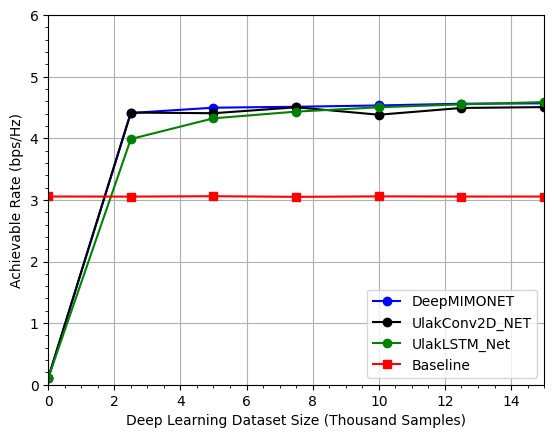

In [33]:
DL_size_array=np.arange(0, 2.5*(num_files), 2.5);

fig, ax = plt.subplots()
#plt.plot(DL_size_array, opt_rate, '--k', label = 'Genie-aided')
plt.plot(DL_size_array, eff_rate_DeepMIMONET*overhead_DL, '-bo', label = 'DeepMIMONET')
#plt.plot(DL_size_array, eff_rate_UlakNET*overhead_DL, '-go', label = 'UlakNET')
#plt.plot(DL_size_array, eff_rate_UlakCNNNET*overhead_DL, '-ko', label = 'UlakCNNNET')
plt.plot(DL_size_array, eff_rate_UlakConv2D_Net*overhead_DL, '-ko', label = 'UlakConv2D_NET')
plt.plot(DL_size_array, eff_rate_UlakLSTM_Net*overhead_DL, '-go', label = 'UlakLSTM_Net')
#plt.plot(DL_size_array, eff_rate_UlakBiLSTM_Net*overhead_DL, '-mo', label = 'UlakBiLSTM_Net')
plt.plot(DL_size_array, opt_rate*overhead_opt, '-rs', label = 'Baseline')
plt.ylim([0, 6])
plt.xlim([0, 15])
plt.minorticks_on()
plt.grid()
plt.xlabel('Deep Learning Dataset Size (Thousand Samples)')
plt.ylabel('Achievable Rate (bps/Hz)')
plt.legend()
plt.savefig('result.png')
